# Kaggle : New York City Taxi Trip Duration
### Share code and data to improve ride time predictions

https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels

# 1 EDA (Exploratory Data Analysis)

# purpose of  EDA

- Suggest hypotheses about the causes of observed phenomena
- Assess assumptions on which statistical inference will be based
- Support the selection of appropriate statistical tools and techniques
- Provide a basis for further data collection through surveys or experiments

# EDA methods
- Graphical techniques used in EDA are:
    - boxplot 
        - detailed feature (datetime by month, day of week, hours)
    - historgram or barplot (distribution) # bin = range of value
        - origin feature (pick lat,long, drop lat, long, duration, passenger count, flag)
        - detailed feature (datetime by month, day of week, hours)
    - scatter plot
        - duration vs distance = to check odd data
    - Parallel Coordinates vs Colormaps vs Andrews curves charts
    - odd ratio????

- Quantative methods:
    - Trimean == tukey method?

# 1.1 Understanding data 

In [26]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import seaborn as sns
import ipyleaflet
from math import sin, cos, sqrt, atan2, radians
import folium
import folium.plugins as plugins
import os
from folium.plugins import MarkerCluster     # Map
from geographiclib.geodesic import Geodesic  # Map
import time, datetime                        # time data
import calendar
import scipy


%matplotlib inline

In [27]:
train = pd.read_csv("~/Documents/taxi_data/train.csv")
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# 1.1.a Data type and unit

# unit

### latitude / longtitude = decimal degree (111.32mm per 0.000001°)
- ex) 40.767937 / -73.982155

### duration = sec
- ex) 455 sec = 7min 35sec

### vendor_id = 1, 2

### passenger_count = 0,,,,9

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [29]:
# train.describe()

In [30]:
9.594923e+02

959.4923

### Sampling

In [31]:
np.random.seed(2)
train = train.sample(frac=0.001, replace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 100879 to 843651
Data columns (total 11 columns):
id                    1459 non-null object
vendor_id             1459 non-null int64
pickup_datetime       1459 non-null object
dropoff_datetime      1459 non-null object
passenger_count       1459 non-null int64
pickup_longitude      1459 non-null float64
pickup_latitude       1459 non-null float64
dropoff_longitude     1459 non-null float64
dropoff_latitude      1459 non-null float64
store_and_fwd_flag    1459 non-null object
trip_duration         1459 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 136.8+ KB


# 1.1.b Missing Data check

In [32]:
#none of missing data
train2 = train.dropna(how = 'any')

len(train) == len(train2)

True

### NYC Taxi Trip Duration [Train data]는

### 총 1,458,644 Row와 11 Column으로 구성되어 있으며,

### Missing Data는 존재하지 않습니다.

# 1.1.c Column information

- id : 개별 Taxi에 부여된 고유 id (이건 그냥 쓴거예요...)
- verdor_id : Taxi Company id >>>  1, 2로 구성되어 있는걸로 봐서 2개의 회사를 대상
- pickup/dropoff datetime : 출발/도착 시간정보 >> 년, 월, 일, 시각 정보가 포함
- passenger_count : 승객수 >>> 0~9명까지 존재
- pickup/dropoff_longitude & latitude : 출발/도착 지리정보
- store_and_fwd_flag : whether the trip data was sent immediately to the vendor (“N”) or held in the memory of the taxi because there was no connection to the server (“Y”)
- trip_duration : 탑승시간 >>> 단위는 Seconds

# 1.2 Feature Engineering & Data Cleaning

### 1.2.a Add columns with detailed informations


- duration per min
- datetime per hour
- datetime per day of week
- datetime per month

In [33]:
#data type convert to datetime from object
train["pickup_datetime"] =  pd.to_datetime(train["pickup_datetime"])
train["dropoff_datetime"] =  pd.to_datetime(train["dropoff_datetime"])

In [34]:
#day of week
#Monday=0, Sunday=6
train["pick_dayofweek"] = train["pickup_datetime"].dt.dayofweek.astype("int")
train["drop_dayofweek"] = train["dropoff_datetime"].dt.dayofweek.astype("int")

#date by month
train["pick_dayofmonth"] = train["pickup_datetime"].dt.month.astype("int")
train["drop_dayofmonth"] = train["dropoff_datetime"].dt.month.astype("int")

#date by hour
train["pick_datehour"] = train["pickup_datetime"].dt.hour.astype("int")
train["drop_datehour"] = train["dropoff_datetime"].dt.hour.astype("int")

# 1.2.b Distance between pickup and dropoff location

In [35]:
# approximate radius of earth in km
R = 6371.0

dist = []

for i in range(len(train)):
    lat1 = radians(train.iloc[i,6])
    lon1 = radians(train.iloc[i,5])
    lat2 = radians(train.iloc[i,8])
    lon2 = radians(train.iloc[i,7])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    dist.append(distance)
    
train['distance'] = dist

In [36]:
train.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pick_dayofweek,drop_dayofweek,pick_dayofmonth,drop_dayofmonth,pick_datehour,drop_datehour,distance
100879,id0673821,2,2016-03-19 20:53:44,2016-03-19 21:18:11,2,-73.990944,40.732998,-73.944931,40.774727,N,1467,5,5,3,3,20,21,6.045803
203245,id3465534,2,2016-04-25 14:31:34,2016-04-25 14:37:05,2,-73.982185,40.752148,-73.988281,40.742992,N,331,0,0,4,4,14,14,1.140205
1133010,id1354600,1,2016-05-04 16:35:10,2016-05-04 16:41:07,1,-73.969307,40.760986,-73.978966,40.747524,N,357,2,2,5,5,16,16,1.703721
961799,id3014975,1,2016-01-16 10:41:51,2016-01-16 10:56:41,1,-73.986877,40.766727,-73.955513,40.826473,N,890,5,5,1,1,10,10,7.148834
1102498,id0962434,1,2016-01-14 04:30:56,2016-01-14 04:34:37,1,-73.981865,40.758327,-73.991219,40.750141,N,221,3,3,1,1,4,4,1.203892


# 1.2.c Outlier Removal

In [96]:
#outlier IQR method
#out of 75 percent value
train_1 = pd.DataFrame.quantile(train, q = 0.75)
train_1

#out of 25 percent value
train_3 = pd.DataFrame.quantile(train, q = 0.25)
train_3

iqr = train_3 - train_1
iqr

lower_bound = train_1 - (iqr * 1.5)
upper_bound = train_3 + (iqr * 1.5)

In [121]:
#removal outliers by IQR method
train = train[train['pickup_longitude'] <= lower_bound["pickup_longitude"]]
train = train[train['pickup_longitude'] >= upper_bound["pickup_longitude"]]
train = train[train['pickup_latitude'] <= lower_bound["pickup_latitude"]]
train = train[train['pickup_latitude'] >= upper_bound["pickup_latitude"]]
train = train[train['dropoff_longitude'] <= lower_bound["dropoff_longitude"]]
train = train[train['dropoff_longitude'] >= upper_bound["dropoff_longitude"]]
train = train[train['dropoff_latitude'] <= lower_bound["dropoff_latitude"]]
train = train[train['dropoff_latitude'] >= upper_bound["dropoff_latitude"]]
train = train[train['trip_duration'] <= lower_bound["trip_duration"]]
train = train[train['trip_duration'] >= upper_bound["trip_duration"]]
train = train[train['distance'] <= lower_bound["distance"]]
train = train[train['distance'] >= upper_bound["distance"]]

In [122]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pick_dayofweek,drop_dayofweek,pick_dayofmonth,drop_dayofmonth,pick_datehour,drop_datehour,distance
count,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000
mean,1.516207,1.660454,-73.980983,40.753919,-73.979157,40.754738,657.104538,3.038088,3.033225,3.511345,3.512156,13.830632,13.854133,2.215054
std,0.499940,1.329291,0.016320,0.020055,0.018004,0.023404,389.157213,1.950567,1.952734,1.675243,1.676689,6.404049,6.455145,1.462993
min,1.000000,1.000000,-74.017250,40.700771,-74.017616,40.690136,6.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,-73.992130,40.740767,-73.991432,40.740412,366.250000,1.000000,1.000000,2.000000,2.000000,9.000000,9.000000,1.110198
50%,2.000000,1.000000,-73.981827,40.754930,-73.980297,40.755672,567.000000,3.000000,3.000000,4.000000,4.000000,15.000000,15.000000,1.817349
75%,2.000000,2.000000,-73.969589,40.766460,-73.967934,40.769716,870.750000,5.000000,5.000000,5.000000,5.000000,19.000000,19.000000,2.950104
max,2.000000,6.000000,-73.930412,40.809578,-73.920677,40.818329,1953.000000,6.000000,6.000000,6.000000,7.000000,23.000000,23.000000,7.628696


# 1.2.d Indivisual feature visualization

- boxplot
- histogram
- jointplot

# y value = % of value

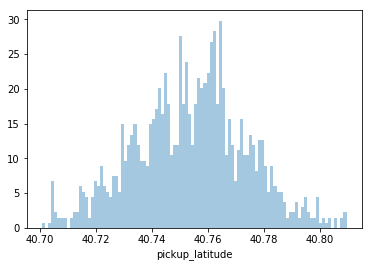

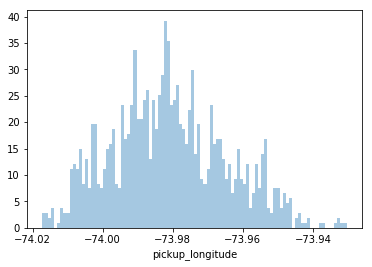

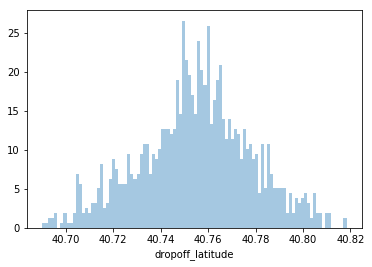

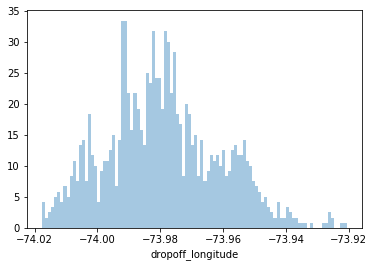

In [109]:
#taxi location latitude, longitude distribution
ax1 = sns.distplot(train["pickup_latitude"], bins = 100, kde=False, norm_hist=True);
plt.xlabel('pickup_latitude')
plt.show()

ax2 = sns.distplot(train["pickup_longitude"], bins = 100, kde=False, norm_hist=True);
plt.xlabel('pickup_longitude')
plt.show()

ax3 = sns.distplot(train["dropoff_latitude"], bins = 100, kde=False, norm_hist=True);
plt.xlabel('dropoff_latitude')
plt.show()

ax4 = sns.distplot(train["dropoff_longitude"], bins = 100, kde=False, norm_hist=True);
plt.xlabel('dropoff_longitude')
plt.show()

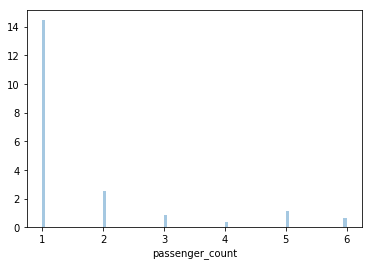

In [110]:
#passenger count
ax1 = sns.distplot(train["passenger_count"], bins = 100, kde=False, norm_hist=True);
plt.xlabel('passenger_count')
plt.show()

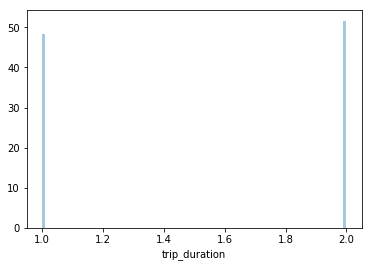

In [111]:
#duration
ax1 = sns.distplot(train["vendor_id"], bins=100, kde=False, norm_hist=True);
plt.xlabel('trip_duration')
plt.show()

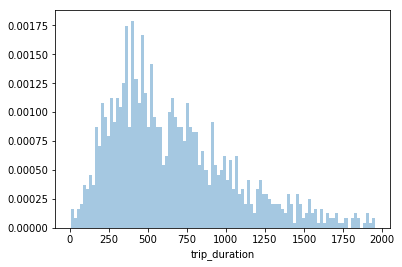

In [112]:
#duration
ax1 = sns.distplot(train["trip_duration"], bins=100, kde=False, norm_hist=True);
plt.xlabel('trip_duration')
plt.show()

/home/jk/enter/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


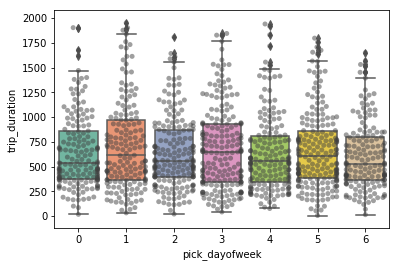

In [113]:
#pick day of week boxplot
ax1 = sns.boxplot(train["pick_dayofweek"],  train["trip_duration"], palette= 'Set2')
ax2 = sns.swarmplot(train["pick_dayofweek"],  train["trip_duration"], color="0.25", alpha=.5)
plt.show()

/home/jk/enter/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


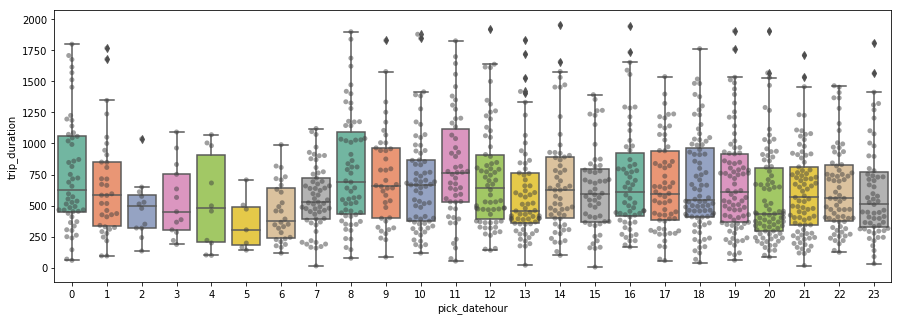

In [114]:
#pick hours boxplot
fig = plt.figure(figsize=(15,5))
ax1 = sns.boxplot(train["pick_datehour"],  train["trip_duration"], palette= 'Set2')
ax2 = sns.swarmplot(train["pick_datehour"],  train["trip_duration"],  color="0.25", alpha=.5)
plt.show()

/home/jk/enter/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


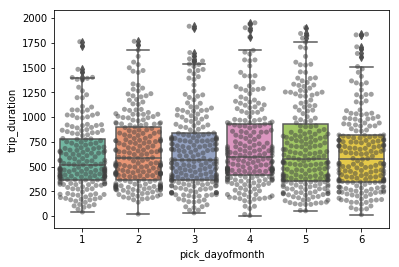

In [115]:
#pick month boxplot
ax1 = sns.boxplot(train["pick_dayofmonth"],  train["trip_duration"], palette= 'Set2')
ax2 = sns.swarmplot(train["pick_dayofmonth"],  train["trip_duration"],  color="0.25", alpha=.5)
plt.show()

/home/jk/enter/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


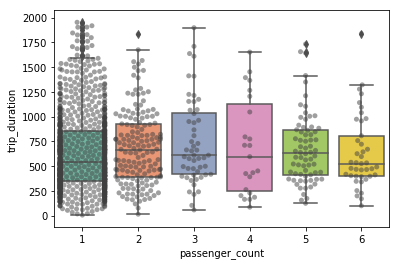

In [116]:
#pick passenger count boxplot
ax1 = sns.boxplot(train["passenger_count"],  train["trip_duration"], palette= 'Set2')
ax2 = sns.swarmplot(train["passenger_count"],  train["trip_duration"],  color="0.25", alpha=.5)
plt.show()

/home/jk/enter/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


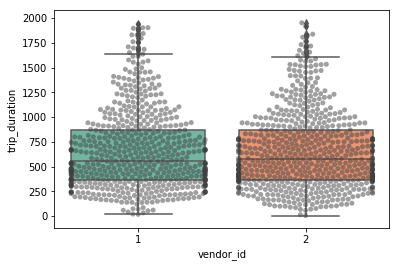

In [117]:
#pick vendor id boxplot
ax1 = sns.boxplot(train["vendor_id"],  train["trip_duration"], palette= 'Set2')
ax2 = sns.swarmplot(train["vendor_id"],  train["trip_duration"], color="0.25", alpha=.5)
plt.show()

/home/jk/enter/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


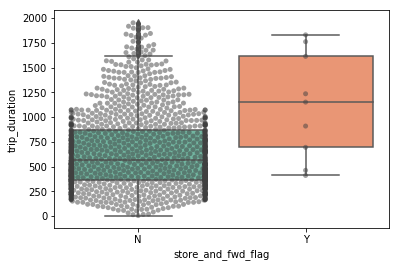

In [118]:
#pick store boxplot
ax1 = sns.boxplot(train["store_and_fwd_flag"],  train["trip_duration"], palette= 'Set2')
ax2 = sns.swarmplot(train["store_and_fwd_flag"],  train["trip_duration"], color="0.25", alpha=.5)
plt.show()

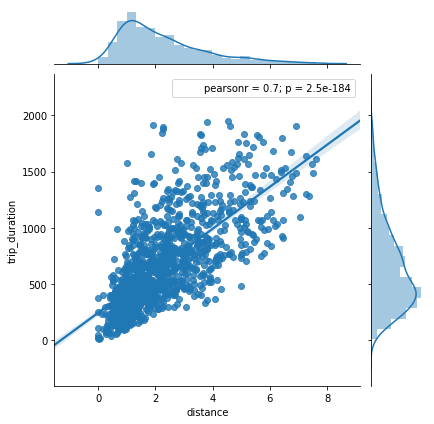

In [119]:
 ## distance와 trip_duration의 jointplot
ax1 = sns.jointplot(train['distance'], train['trip_duration'], kind = 'reg')
plt.show()

In [ ]:
 ## distance와 trip_duration의 jointplot
ax1 = sns.jointplot(train['distance'], train['trip_duration'], kind = 'reg')
plt.show()

# 1.2.d Map Visualization

- locate data onto NYC map (pickup location)

In [124]:
# interactive map visualization
# pick location and count data on the map
#center location
center=[np.mean(train['pickup_latitude']), np.mean(train['pickup_longitude'])]

m = folium.Map(location = center, zoom_start=10)

marker_cluster = MarkerCluster(
    name='1000 clustered icons',
    overlay=True,
    control=False,
    icon_create_function=None
)

for i in range(len(train)):
    location1=[train.iloc[i, 6], train.iloc[i, 5]]
    folium.CircleMarker(
        location=location1,
        radius=1,
        color = "blue"
      ).add_to(m)
    marker = folium.Marker(location=location1)
    marker_cluster.add_child(marker)
    marker_cluster.add_to(m)
    
m

# 1.3 EDA Interpretation & conclusion